
## Facial emotion



Facial emotion recognition software is mostly used to allow a certain program to examine and process the expressions on a human’s face.

This software acts like a human brain making it capable of recognizing emotions too.




### Technical challenges




Like any machine learning and deep learning algorithms, ER solutions require a lot of training data.



This data must include photos from various angles, with various backgrounds, with people of different genders, ages, nationalities, races, etc.



However, most public datasets aren’t sufficient. They aren’t diverse enough in terms of race and gender and contain limited sets of emotional expressions.



There are some ways to overcome this issue:



 - Create your own dataset.

   This is the most expensive and time-consuming way, but you’ll end

   up with a dataset perfectly suited for your task

   (recommended but almost impossible for individuals)



 - Combine several datasets. You can cross-check the performance of

   your solution on several other datasets.



Nowdays, ER is used for various purposes on a daily basis that almost no-one can't even notice.



Investigations, job interviews and security are a small part of all possible application

we can detect the emotions of a person with just the use of this technology


The more accurate and reliable the ER process is, the more we can use it for human resources and security on a regular basis.

And will make a great contribution to humanity.


We choose the topic out of an understanding of its importance, the technological challenge, and the great potential inherent in it.


With pleasure,
Haim Kalfon and Shira Constantiner
Computer Science Students at Open University of Israel

### What will be the workflow of this project?

* First, We will explore the dataset and attempt to make EDA of data (Done)
* Later preprocess the data as requried, this includes image augumentations, scaling and what else need? (Done)
* Try to build a basic vanilla CNN, and try to predict species as a binary classification problem
* Later try to make predictions with transfer learning using ResNet50 and imagenet weights (In future)
* Finally compare the results on vanilla CNN and ResNet50 with sample data

#### Domain - dataset of images

##### CK+48

```
The data consists of 48x48 pixel grayscale images of faces.
The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image.

The dataset is separated into seven classes wich are (0=Anger, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
The dataset consists of 783 images for training and 198 images for testing (we update class labels to match 'emotions' then we ran a script to split images into train and test datasets)
```

To downloaded CK+48 dataset [Click here](https://www.kaggle.com/datasets/shawon10/ckplus/download)

##### FER13

```
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Anger, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.
```

To downloaded FER13 dataset [Click here](https://www.kaggle.com/datasets/msambare/fer2013) 

Now it's time to start our coding journey

In [42]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [43]:
DEBUG = True

# Labels
emotions = ["anger", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Datasets directories
FER13_PATH = './FER13'
CK48_PATH = './CK+48'
FERG_PATH = './FERG_DB_256'

class Params:
	# Visualization
	FIG_SIZE = (10, 10)
	PIC_SIZE = 50

	# Images parameters for data augmentation and loading data
	GRAY_SCALE = False
	ROTATION_FACTOR = .1
	ZOOM_FACTOR = .1
	CONTRAST_FACTOR = .1

	# Dataset parameters
	SEED = 4242
	IMAGE_HEIGHT = 48
	IMAGE_WIDTH = 48
	VALIDATION_SPLIT = 0.2

	# Neural Network hyperparameters
	DROPOUT_RATE = 0.2
	PATIENCE = 5
	NUM_CLASSES = 7
	EPOCHS = 30
	BATCH_SIZE = 64
	BUFFER_SIZE = 128

	CHANNELS = 1 if GRAY_SCALE else 3
	SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)

Params = Params()

def update_channel_and_shapes(params):
	params.CHANNELS = 1 if params.GRAY_SCALE else 3
	params.SHAPE = (params.IMAGE_HEIGHT, params.IMAGE_WIDTH, params.CHANNELS)

Lets write some utils functions

In [44]:
import cv2 as cv
import seaborn as sns
from sklearn.metrics import confusion_matrix

def _debug(str):
	if DEBUG: print(f'[DEBUG] {str}')

def _reshape_image(img):
	'''
		Assume the image has 3 channels the reshape it to 1 channel 
	'''
	gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
	gray = cv.resize(gray, (Params.IMAGE_HEIGHT, Params.IMAGE_WIDTH))
	
	reshaped = gray.reshape(Params.SHAPE)
	_debug(reshaped.shape)
	return reshaped

def _plot_image(dataset, rescale=False, contrast = False):
	image = None
	for images, _ in dataset.take(1):
		image = images[0]
	
	if image == None: return
	image = image.numpy()
	# if not GRAY_SCALE: image = _reshape_image(image)

	_debug(f'Rescale is set to {rescale}')
	cmap = None

	plt.figure()
	if rescale: 
		image = image/255.
		if contrast: image = 1 - image
		cmap = plt.cm.binary
		plt.imshow(image, cmap=cmap)
	else: plt.imshow(image.astype('uint8'))
	
	plt.title(f'Values are in range({np.min(image)}, {np.max(image)})')
	plt.colorbar()
	plt.grid(False)
	plt.show()

def visualize_dataset(dataset):
	'''
		Summary: Helper to visualize our dataset images

		Arguments: Accept a Dataset 

		Retruns: None, plot images
	'''

	plt.figure(figsize=Params.FIG_SIZE)
	for images, labels in dataset.take(1):
		for i in range(9):
			ax = plt.subplot(3, 3, i + 1)
			image = images[i].numpy()
			_debug(f'Image shape is: {image.shape}')
			plt.imshow(image.astype("uint8"))
			plt.title(dataset.class_names[labels[i]])
			
	plt.show()

def plot_image_values_range(dataset):
	_plot_image(dataset)

def plot_rescaled_image(dataset):
	_plot_image(dataset, True)

def plot_bar_chart(dataset, validation_dataset, name):
	'''
		Summary: Helper to visualize our train and validation dataset images distibution by classes 

		Arguments: Accept a train Dataset, validation Dataset, and a name as title

		Retruns: None, plot bar diagram
	'''

	x = np.arange(len(emotions))
	width = .35

	fig, ax = plt.subplots()

	for _, labels in dataset.take(1):
		per_classes = np.bincount(labels)
		train_bar = ax.bar(x - width/2, per_classes, tick_label = emotions, width = width, label='Train')
		ax.bar_label(train_bar, padding=3)

	for _, labels_val in validation_dataset.take(1):
		per_classes_val =  np.bincount(labels_val)
		validation_bar = ax.bar(x + width/2, per_classes_val, tick_label = emotions,width = width, label='Validation')
		ax.bar_label(validation_bar, padding=3)

	ax.set_ylabel('# Images')
	ax.set_title(f'Number of Images by Class for {name} dataset')
	ax.set_xlabel('Class Name')
	ax.legend()
	
	plt.show()

def plot_accuracy_and_loss(history, name):

	'''
		Summary: Helper to visualize the diagram of  train and validation dataset images accuracy and loss 
			after model training

		Arguments: Accept a history (from model.fit()) and the name of our Dataset

		Retruns: None, plot accuracy and loss graph diagram
	'''
	
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs_range = range(len(acc))	
	plt.figure(figsize=(15, 15))
	
	plt.subplot(2, 2, 1)
	plt.plot(epochs_range, loss, label='Training Loss')
	plt.plot(epochs_range, val_loss, label='Validation Loss')
	plt.legend(loc='upper right')
	plt.title(f'Training and Validation Loss for {name} dataset')
	plt.grid(True)
	plt.axis('on')

	plt.subplot(2, 2, 2)
	plt.plot(epochs_range, acc, label='Training Accuracy')
	plt.plot(epochs_range, val_acc, label='Validation Accuracy')
	plt.legend(loc='lower right')
	plt.title(f'Training and Validation Accuracy for {name} dataset')
	plt.grid(True)
	plt.axis('on')
	
	plt.show()

def _plot_confusion_matrix(labels, predictions):

	def map_labels_to_index(arr):
		return np.vectorize(lambda x: emotions[x])(arr)

	labels = map_labels_to_index(labels)
	predictions = map_labels_to_index(predictions)

	_debug(f'Display 10 labels: {labels[:10]}')
	_debug(f'Display 10 predictions: {predictions[:10]}')

	cm = confusion_matrix(labels, predictions, emotions)
	
	df_cm = pd.DataFrame(cm, index = emotions, columns = emotions)
	plt.figure(figsize=Params.FIG_SIZE)
	sns.heatmap(df_cm, annot=True, fmt="d")
	plt.title('Confusion matrix')
	plt.ylabel('Actual label')
	plt.xlabel('Predicted label')	
	plt.show()

	transposed = cm.transpose()
	
	wrongs, rights = 0, 0
	for i, e in enumerate(emotions):
		right = cm[i][i]
		wrong = np.sum(transposed[i]) - right

		print(f'{e.capitalize()}\n\tRight Classified (True Negatives): {right}\n\t Total Missed Classification: {wrong}')
		rights += right
		wrongs += wrong


	ratio = rights/ np.sum(cm)
	_debug(ratio)
	percentage = '{0:.2f}'.format(ratio*100)
	print(f'\nPercentage of right classifications is {percentage}%"')

def plot_confusion_matrix_for_test_dataset(dataset, predictions):
	# fetch real labels from test dataset (assuming its small enough to iterate over the entire dataset)
	labels = None
	for _, lbls in dataset.as_numpy_iterator():
		if labels is None: labels = lbls.flatten()
		else: labels = np.concatenate([labels, lbls.flatten()])

	_plot_confusion_matrix(labels, predictions)

def plot_confusion_matrix_for_train_dataset(dataset, predictions):

	# fetch real labels from dataset batch
	labels = None
	for _, lbls in dataset.take(1):
		if labels is None: labels = lbls
		else: labels = np.concatenate([labels, lbls])

	_plot_confusion_matrix(labels, predictions)

Here we write utils functions to help us dealing with creating our dataset

Because our dataset is a set of images we don't want to load it all in RAM that why we make use of keras function image_dataset_from_directory

In [45]:
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

def _color_mode():
	return 'grayscale' if Params.GRAY_SCALE else 'rgb'

def _preprocessing(dataset):
	ds = dataset.cache()
	ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

	return ds

def _train_from_dir(path, subset):
	ds = image_dataset_from_directory(path,
		validation_split=Params.VALIDATION_SPLIT,
		seed=Params.SEED,
		subset=subset,
		shuffle=True,
		image_size=(Params.IMAGE_HEIGHT, Params.IMAGE_WIDTH),
		color_mode=_color_mode(),
		batch_size=Params.BATCH_SIZE)
		
	return ds

def _test_from_dir(path):
	ds = image_dataset_from_directory(path,
		seed=Params.SEED,
		shuffle=True,
		image_size=(Params.IMAGE_HEIGHT, Params.IMAGE_WIDTH),
		color_mode=_color_mode())

	return ds

def load_data(path):
	'''
		Summary: Helper to load our data into 3 dataset, train, validation and test
				the validation is part of train folder splited by VALIDATION_SPLIT factor variable

		Arguments: Accept a path for main directory of a specific dataset (must have 'train' and 'test' sub-directories)

		Retruns: Tuple (train_ds, validation_ds, test_ds)
	'''

	test_path = f'{path}/test'
	train_path = f'{path}/train'
	train = _train_from_dir(train_path, 'training')
	validation = _train_from_dir(train_path, 'validation')
	test = _test_from_dir(test_path)

	return (train, validation, test)

def _images_per_emotions(main_dir):
	'''
		Summary: Return an array of number of images per emotion (keep the same order as emotion array)
		Arguments: The main directory (should have train and test directory)
		Return: Array as described above
	'''

	labels = []

	path_dir = pathlib.Path(main_dir)
	_debug(f'Directory name is {path_dir.name }')
	_debug(f'list of sub-directories: {os.listdir(main_dir)}')

	dirs = [e for e in path_dir.iterdir() if e.is_dir() and e.name == 'train' ]
	if not len(dirs) > 0: print('Directory given is empty...')

	emotions_dir = [e for e in dirs[0].iterdir() if e.is_dir()]
	for emotion in emotions_dir:
		#_debug(f'emotion: {emotion.name}')
		count = len([name for name in os.listdir(emotion) if os.path.isfile(os.path.join(emotion, name))])
		labels.append(count)

	
	_debug(f'labels_count from emotions {len(labels)}')
	return labels

def get_updated_class_weights(path):
	labels_count = _images_per_emotions(path)
	_debug(f'labels_count {labels_count}')

	labels_sum = np.sum(labels_count)
	_debug(f'labels sum {labels_sum}')

	labels_count = labels_count/labels_sum
	_debug(f'updated labels_count {labels_count}')

	classes_weights = dict(enumerate(labels_count))
	_debug(classes_weights)
	return classes_weights

def display_dataset_infos(train_dataset, test_dataset):
	print("Number of training examples =", train_dataset.cardinality().numpy())
	print("Number of testing examples =",  test_dataset.cardinality().numpy())
	print("Number of classes =", len(train_dataset.class_names))
	print("Classes names =", train_dataset.class_names)

Here we set a basic model params class to hold some helpful params for the neural networks we will create latter

In [46]:
class ModelParams():
	def __init__(self, optimiser, loss, metrics):
		self.optimiser = optimiser
		self.loss = loss
		self.metrics = metrics

	def set_optimiser(optimiser):
		self.optimiser = optimiser

	def set_loss(loss):
		self.loss = loss
	
	def set_metrics(metrics):
		self.metrics = metrics

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, TensorBoard, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# will decrease learning rate exponentialy after 10 epochs
def _scheduler(epoch, lr):
	return lr if epoch < 10 else lr * tf.math.exp(-.1)


def _callbacks():
	log_dir = os.path.join('./', 'logs') 

	early_stopping = EarlyStopping(mode='min', min_delta=1e-4, patience=Params.PATIENCE, verbose=1, monitor='val_loss', restore_best_weights=True)
	csv_logger = CSVLogger('model_training.log', separator=",", append=False)
	tensor_board = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False,write_steps_per_second=True,update_freq='batch',profile_batch=10,embeddings_freq=0,embeddings_metadata=None)
	learning_rate_scheduler = LearningRateScheduler(schedule=_scheduler)
	# you may add more callbacks here, make sure you add it to the returned array

	return [early_stopping, csv_logger, tensor_board, learning_rate_scheduler]

def _optimiser():
	# you may want to modify those values
	#opt = SGD(learning_rate= 1e-3, decay= 1e-4, momentum=.9)
	opt = Adam(learning_rate=1e-4, decay= 1e-3)

	return opt

def _loss():
	# you may want to change the loss function
	loss = SparseCategoricalCrossentropy(from_logits=True)
	
	return loss

def _metrics():
	# add metrics you want below
	return ['accuracy']

Next step is to load our data, we'll first start with data without any modification 

In [48]:
ck_train_ds, ck_validation_ds, ck_test_ds = load_data(CK48_PATH)

Found 783 files belonging to 7 classes.
Using 627 files for training.
Found 783 files belonging to 7 classes.
Using 156 files for validation.
Found 198 files belonging to 7 classes.


In [49]:
display_dataset_infos(ck_train_ds, ck_test_ds)

Number of training examples = 10
Number of testing examples = 7
Number of classes = 7
Classes names = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Lets display some visualization of our dataset before training our first model

[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)


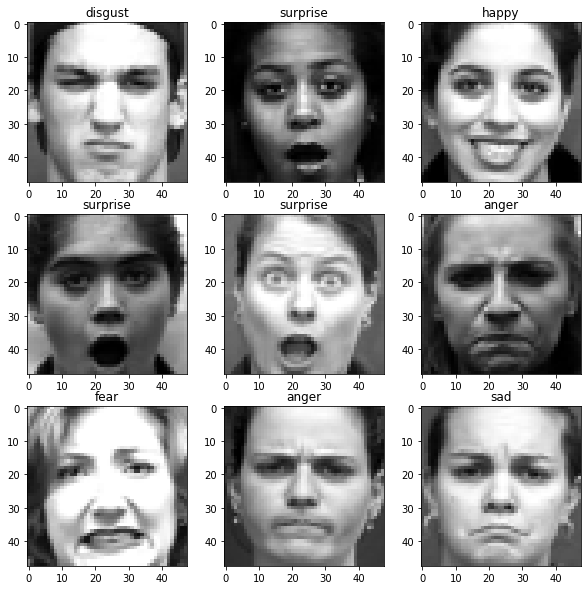

In [50]:
visualize_dataset(ck_train_ds)

We can do the same for the test dataset

[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)
[DEBUG] Image shape is: (48, 48, 3)


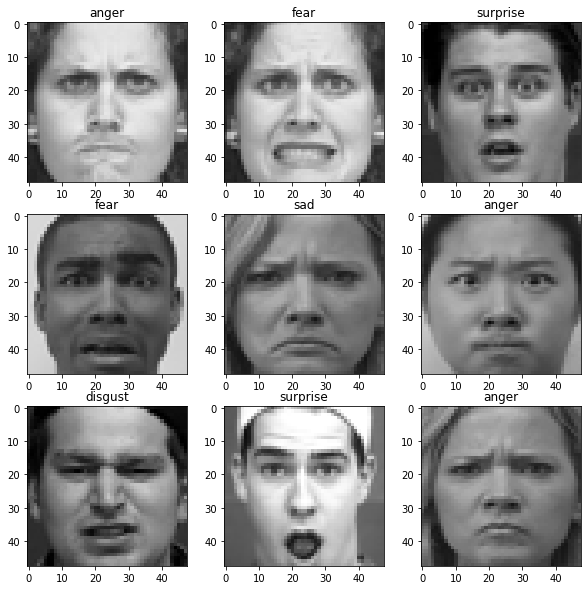

In [51]:
visualize_dataset(ck_test_ds)

Lets see the range values of our images

[DEBUG] Rescale is set to False


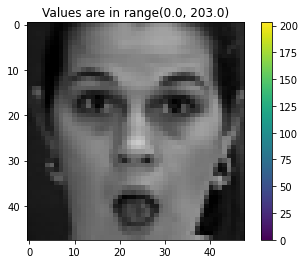

In [52]:
plot_image_values_range(ck_train_ds)

Now we can see that all values are in range of (0, 255)
according to research Neural network are more efficient with scaled images, hence we'll scaled images to (0, 1)

[DEBUG] Rescale is set to True


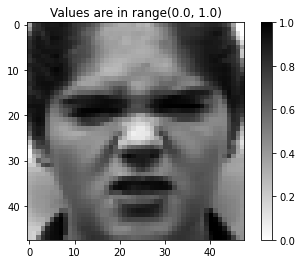

In [53]:
plot_rescaled_image(ck_train_ds)

Lets see the distribution of the dataset, based on one batch only but it should give us a good approcimation of the real dataset distibution

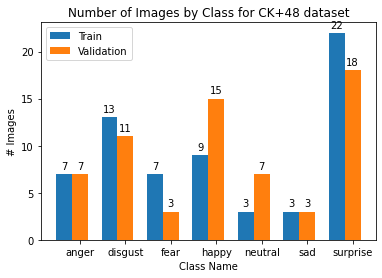

In [54]:
plot_bar_chart(ck_train_ds, ck_validation_ds, 'CK+48')

As we can see one dataset is really unbalanced, despite the fact that we are looking at one batch only
we can see that 'surprise' class has way more items that 'neutral' class

To deal with it we will adjust the weights for every class

Applying this extra step for a balanced dataset should not be bad

In [55]:
ck_class_weight = get_updated_class_weights(CK48_PATH)

[DEBUG] Directory name is CK+48
[DEBUG] list of sub-directories: ['test', 'train']
[DEBUG] labels_count from emotions 7
[DEBUG] labels_count [108, 141, 60, 165, 43, 67, 199]
[DEBUG] labels sum 783
[DEBUG] updated labels_count [0.13793103 0.18007663 0.07662835 0.21072797 0.05491699 0.08556833
 0.2541507 ]
[DEBUG] {0: 0.13793103448275862, 1: 0.18007662835249041, 2: 0.07662835249042145, 3: 0.210727969348659, 4: 0.05491698595146871, 5: 0.08556832694763729, 6: 0.2541507024265645}


#### First attempt

Here we will start with a really basic neural network to see how it works

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D, Dropout, Dense, Flatten, Conv2D

# filters is the numbers of filters used to extract facial components like edges, nose eyes and so on
# density is for the last layer wich is a fully connected layer

def build_basic_model(opt: ModelParams, filters, density):
	model = Sequential()

	model.add(Conv2D(filters, 3, activation='relu',use_bias='True'))
	model.add(MaxPool2D(4))
	model.add(Dropout(Params.DROPOUT_RATE))
	
	model.add(Flatten())
	model.add(Dense(density, activation='relu'))
	model.add(Dense(Params.NUM_CLASSES, activation='softmax', name="pred"))
	
	# Compile
	model.compile(optimizer=opt.optimiser, loss=opt.loss, metrics=opt.metrics)
	
	return model

Let's give our basic model some hyper-parameters

In [57]:
# lets start with SGD optimiser
sgd = SGD(learning_rate= 1e-3, decay= 1e-4, momentum=.9)

model = ModelParams(sgd, _loss(), _metrics())

# lets start with 128 filters
filters = 128 

# density will be same as filters for now
density = 128

cknet = build_basic_model(model, filters, density)

Now that we have compile our basic neural network, lets see what inside

In [58]:
batch_shape = (Params.BATCH_SIZE,) + Params.SHAPE
cknet.build(batch_shape)

cknet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (64, 46, 46, 128)         3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (64, 11, 11, 128)        0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (64, 11, 11, 128)         0         
                                                                 
 flatten_3 (Flatten)         (64, 15488)               0         
                                                                 
 dense_3 (Dense)             (64, 128)                 1982592   
                                                                 
 pred (Dense)                (64, 7)                   903       
                                                      

It's time to train our model with some data

In [59]:
Params.EPOCHS= 10
cknet_hist = cknet.fit(ck_train_ds, class_weight=ck_class_weight, callbacks= _callbacks(), verbose = 1,
	shuffle = True, validation_data = ck_validation_ds, batch_size = Params.BATCH_SIZE, epochs = Params.EPOCHS)

Epoch 1/10


c:\Users\Haim Kalfon\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 3s 230ms/step - loss: 16.4569 - accuracy: 0.1770 - val_loss: 1.7185 - val_accuracy: 0.3462 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 2s 172ms/step - loss: 0.2323 - accuracy: 0.4242 - val_loss: 1.3655 - val_accuracy: 0.5897 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 2s 169ms/step - loss: 0.1558 - accuracy: 0.6108 - val_loss: 1.0593 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 2s 185ms/step - loss: 0.1260 - accuracy: 0.6587 - val_loss: 0.8352 - val_accuracy: 0.7051 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 2s 159ms/step - loss: 0.1014 - accuracy: 0.6954 - val_loss: 0.7318 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 2s 161ms/step - loss: 0.0856 - accuracy: 0.7305 - val_loss: 0.6689 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 2s 164ms/step - loss: 0.0714

Our basic neural network is trained, let's see it's score

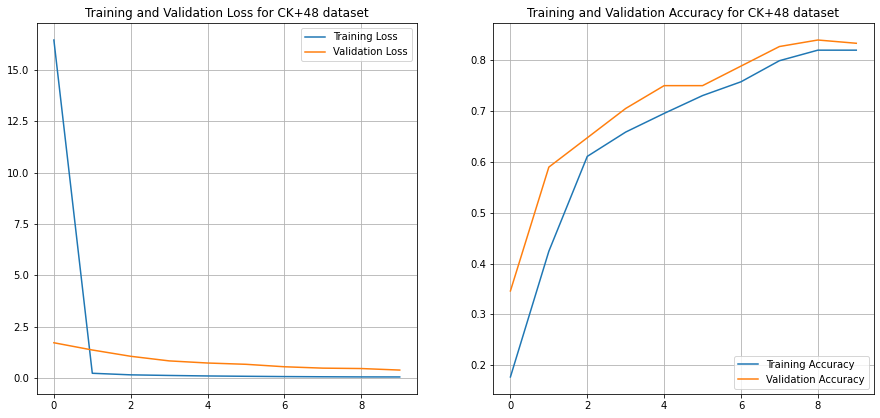

In [60]:
plot_accuracy_and_loss(cknet_hist, "CK+48")

A strange thing just happend, the validation accuracy is better than the training accuracy,
we can try to predict on our test dataset 

In [61]:
ck_predictions = cknet.predict(ck_test_ds,verbose = 1,batch_size = Params.BATCH_SIZE)
ck_class_index = np.argmax(ck_predictions, axis=1)

7/7 [==============================] - 0s 15ms/step


Now that we used our neural netwok on test dataset its time to show the results,

A confusion matrix seems to be a good idea

[DEBUG] Display 10 labels: ['happy' 'happy' 'fear' 'anger' 'sad' 'happy' 'happy' 'anger' 'happy'
 'disgust']
[DEBUG] Display 10 predictions: ['disgust' 'surprise' 'happy' 'surprise' 'disgust' 'neutral' 'happy'
 'anger' 'disgust' 'happy']


c:\Users\Haim Kalfon\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


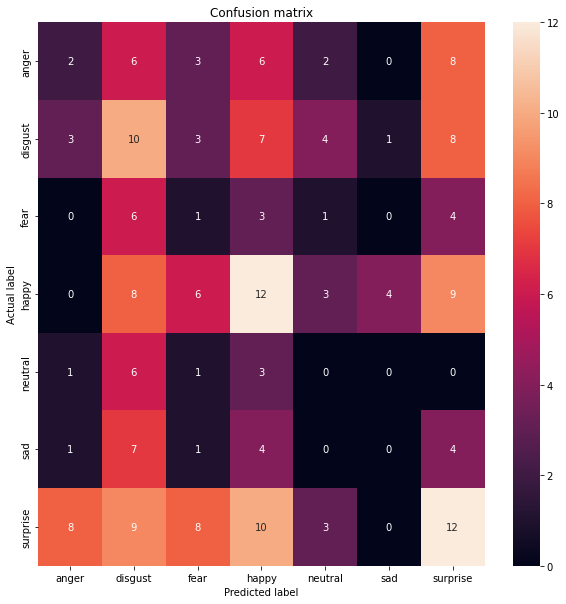

Anger
	Right Classified (True Negatives): 2
	 Total Missed Classification: 13
Disgust
	Right Classified (True Negatives): 10
	 Total Missed Classification: 42
Fear
	Right Classified (True Negatives): 1
	 Total Missed Classification: 22
Happy
	Right Classified (True Negatives): 12
	 Total Missed Classification: 33
Neutral
	Right Classified (True Negatives): 0
	 Total Missed Classification: 13
Sad
	Right Classified (True Negatives): 0
	 Total Missed Classification: 5
Surprise
	Right Classified (True Negatives): 12
	 Total Missed Classification: 33
[DEBUG] 0.18686868686868688

Percentage of right classifications is 18.69%"


In [62]:
plot_confusion_matrix_for_test_dataset(ck_test_ds, ck_class_index)

In [63]:
from tensorflow.keras.models import save_model

save_model(cknet, 'ck_model_v1.h5', include_optimizer=True)
np.save('ck_model_v1.weights.h5', cknet.get_weights())

c:\Users\Haim Kalfon\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


We can clearly see that our model performs really bad, lets try to fix that.

#### Second attempt
To overcome the poor performance of our precedent model we'll use a more complex CNN

In [64]:
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import BatchNormalization

def build_model(opt: ModelParams):
	model = Sequential()

	model.add(Conv2D(512, 3,name='conv2d_1', activation='relu',use_bias='True',kernel_regularizer=L2(1e-3), bias_regularizer=L2(1e-4)))
	model.add(MaxPool2D(3))
	model.add(Dropout(Params.DROPOUT_RATE)) # to prevent overfitting
	
	model.add(Conv2D(256, 3,name='conv2d_2', activation='relu',use_bias='True'))
	model.add(MaxPool2D(3))
	model.add(BatchNormalization())

	model.add(Conv2D(128, 3,name='conv2d_3', activation='relu', padding='same', use_bias='True', kernel_regularizer=L2(1e-3), bias_regularizer=L2(1e-4)))
	model.add(MaxPool2D(3))
	model.add(Dropout(Params.DROPOUT_RATE))
	
	
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(Params.NUM_CLASSES, activation='softmax', name="pred"))
	
	model.compile(optimizer=opt.optimiser, loss= opt.loss, metrics=opt.metrics)

	return model

Lets build the more complex model, hopping that it will give us better performance

In [65]:
model = ModelParams(_optimiser(), _loss(), _metrics())
cknet = build_model(model)

Lets see what inside our new model

In [66]:
cknet.build(batch_shape)

cknet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (64, 46, 46, 512)         14336     
                                                                 
 max_pooling2d_8 (MaxPooling  (64, 15, 15, 512)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (64, 15, 15, 512)         0         
                                                                 
 conv2d_2 (Conv2D)           (64, 13, 13, 256)         1179904   
                                                                 
 max_pooling2d_9 (MaxPooling  (64, 4, 4, 256)          0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (64, 4, 4, 256)         

Lets give our updated model a try, you can feel the excitement!!

In [67]:
cknet_hist = cknet.fit(ck_train_ds, class_weight=ck_class_weight, callbacks= _callbacks(), verbose = 1,
	shuffle = True, validation_data = ck_validation_ds, batch_size = Params.BATCH_SIZE, epochs = Params.EPOCHS)

Epoch 1/10


c:\Users\Haim Kalfon\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 15s 1s/step - loss: 0.5565 - accuracy: 0.1818 - val_loss: 6.6409 - val_accuracy: 0.2372 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - 13s 1s/step - loss: 0.4903 - accuracy: 0.2695 - val_loss: 3.9768 - val_accuracy: 0.3974 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - 14s 1s/step - loss: 0.4602 - accuracy: 0.3094 - val_loss: 4.0086 - val_accuracy: 0.2692 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 0.4498 - accuracy: 0.3046 - val_loss: 2.5340 - val_accuracy: 0.3397 - lr: 1.0000e-04
Epoch 5/10
 2/10 [=====>........................] - ETA: 10s - loss: 0.4602 - accuracy: 0.3281

At every attempt we'll save the model for future use

In [ ]:
save_model(cknet, 'ck_model_v2.h5', include_optimizer=True)
np.save('ck_model_v2.weights.h5', cknet.get_weights())

Deception, it seems that also this neural network didnt perform well
<br/>
Lets check it out

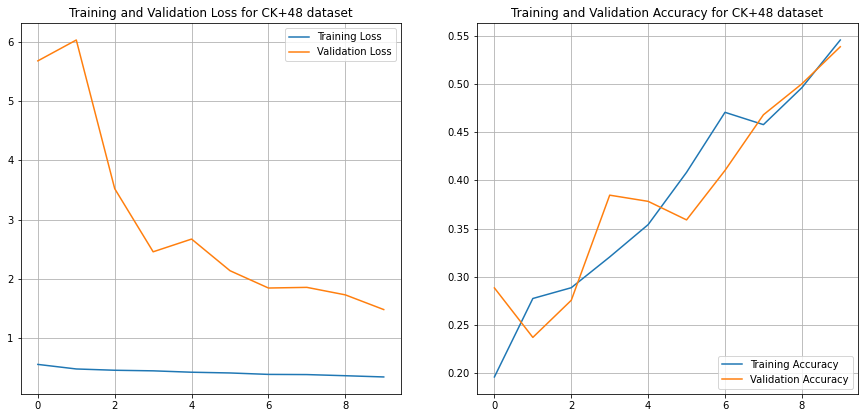

In [ ]:
plot_accuracy_and_loss(cknet_hist, "CK+48")

We can evaluate the model on ck+48 test dataset

In [ ]:
ck_evaluation = cknet.evaluate(ck_test_ds, verbose =1)
ck_loss, ck_accr = ck_evaluation

print("ck_validation loss = {:.2f}% , ck_validation accuracy = {:.2f}%".format(ck_loss*100, ck_accr*100))

7/7 [==============================] - 1s 132ms/step - loss: 1.4565 - accuracy: 0.5354
ck_validation loss = 145.65% , ck_validation accuracy = 53.54%


Here we can clearly see that the accuracy is still too low even if the loss is decreasing
it mights be connected to the fact that our dataset is too small
<br>

Lets this conclusion by plotting the confusion matrix

7/7 [==============================] - 1s 127ms/step
[DEBUG] Display 10 labels: ['disgust' 'sad' 'neutral' 'happy' 'neutral' 'surprise' 'surprise' 'fear'
 'anger' 'disgust']
[DEBUG] Display 10 predictions: ['surprise' 'anger' 'surprise' 'surprise' 'disgust' 'surprise' 'surprise'
 'surprise' 'surprise' 'disgust']


c:\Users\Haim Kalfon\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


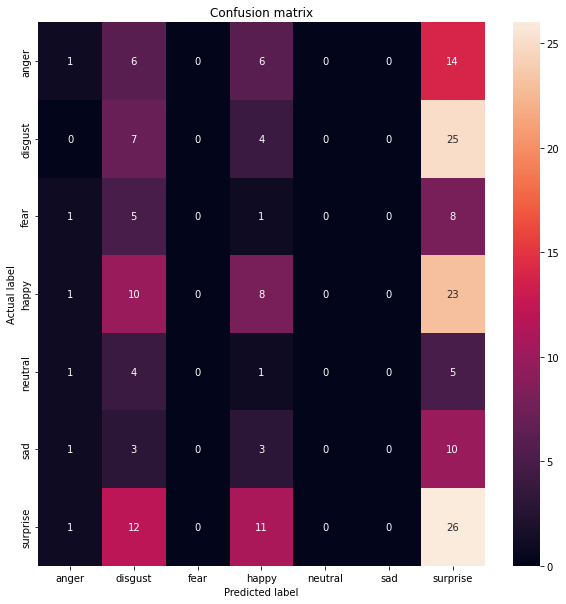

Anger
	Right Classified (True Negatives): 1
	 Total Missed Classification: 26
Disgust
	Right Classified (True Negatives): 7
	 Total Missed Classification: 29
Fear
	Right Classified (True Negatives): 0
	 Total Missed Classification: 15
Happy
	Right Classified (True Negatives): 8
	 Total Missed Classification: 34
Neutral
	Right Classified (True Negatives): 0
	 Total Missed Classification: 11
Sad
	Right Classified (True Negatives): 0
	 Total Missed Classification: 17
Surprise
	Right Classified (True Negatives): 26
	 Total Missed Classification: 24
[DEBUG] 0.21212121212121213

Percentage of right classifications is 21.21%"


In [ ]:
ck_predictions = cknet.predict(ck_test_ds, verbose = 1)
ck_class_index = np.argmax(ck_predictions, axis=1)

plot_confusion_matrix_for_test_dataset(ck_test_ds, ck_class_index)

Saying that we can continue our journey with some data augmentation, we'll keep this model but we will give our model more data

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomRotation, RandomFlip, RandomZoom

def images_augmentation_layers(shape):
	layers = [
		RandomFlip(seed=Params.SEED, input_shape=shape),
		RandomRotation(Params.ROTATION_FACTOR, fill_mode='constant', interpolation='bilinear', seed=Params.SEED, fill_value=.3),
		RandomZoom(Params.ZOOM_FACTOR, .2, fill_mode='reflect', interpolation='nearest', seed=Params.SEED),
		RandomContrast(factor=(.2, .6), seed=Params.SEED),
	]

	return layers

In [ ]:
layers = images_augmentation_layers(Params.SHAPE)
data_augmentation = Sequential(layers)

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

def plot_augmented_images(dataset):
	for images, _ in dataset.take(1):
		plt.figure(figsize=Params.FIG_SIZE)
		original = images[0]
		plt.subplot(3, 3, 9)
		for i in range(9):
			plt.subplot(3, 3, i + 1)
			augmented_images = data_augmentation(tf.expand_dims(original, 0), training=True)
			augmented_image = augmented_images[0]
			augmented_image = augmented_image.numpy()
			plt.imshow(augmented_image.astype('int32'))
			plt.axis("off")
		plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


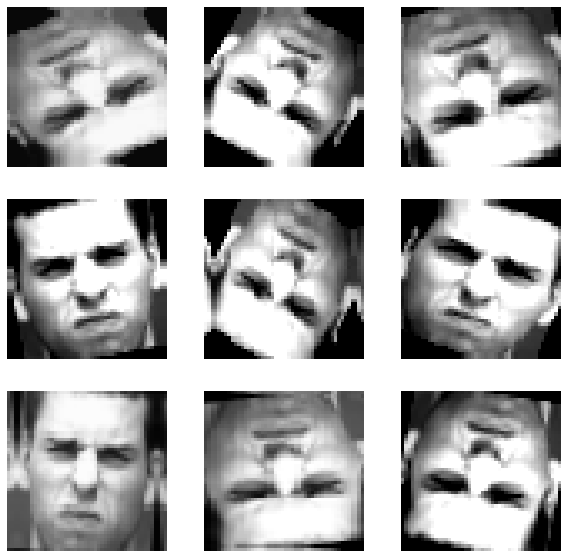

In [ ]:
plot_augmented_images(ck_train_ds)

#### Third attempt

we can now use data augmentation to add more data to our dataset (augmented data)

In [ ]:
def build_model_with_augmentation_layers(opt: ModelParams):
	model = Sequential(layers)

	model.add(Conv2D(512, 3,name='conv2d_1', activation='relu',use_bias='True',kernel_regularizer=L2(1e-3), bias_regularizer=L2(1e-4)))
	model.add(MaxPool2D(3))
	# to avoid overfitting
	model.add(Dropout(Params.DROPOUT_RATE))
	
	model.add(Conv2D(256, 3,name='conv2d_2', activation='relu',use_bias='True'))
	model.add(MaxPool2D(3))
	model.add(BatchNormalization())

	model.add(Conv2D(128, 3,name='conv2d_3', activation='relu', padding='same', use_bias='True', kernel_regularizer=L2(1e-3), bias_regularizer=L2(1e-4)))
	model.add(MaxPool2D(3))
	model.add(Dropout(Params.DROPOUT_RATE))
	
	
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(Params.NUM_CLASSES, activation='softmax', name="pred"))
	
	# Compile
	model.compile(optimizer=opt.optimiser, loss= opt.loss, metrics=opt.metrics)

	return model

In [ ]:
# we dont want to change our base model params so we passing model varaible
cknet = build_model_with_augmentation_layers(model)

In [ ]:
cknet.build(batch_shape)

cknet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 48, 48, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 48, 48, 3)        0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 48, 48, 3)         0         
                                                                 
 random_contrast (RandomCont  (None, 48, 48, 3)        0         
 rast)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 512)       14336     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 512)     

We can see that our new model has image augmentation layers

Its time to train it

In [ ]:
cknet_hist = cknet.fit(ck_train_ds, class_weight=ck_class_weight, callbacks= _callbacks(), verbose = 1,
	shuffle = True, validation_data = ck_validation_ds, batch_size = Params.BATCH_SIZE, epochs = Params.EPOCHS)

Epoch 1/10


c:\Users\Haim Kalfon\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 16s 1s/step - loss: 0.5624 - accuracy: 0.2201 - val_loss: 8.8397 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - 14s 1s/step - loss: 0.5009 - accuracy: 0.2504 - val_loss: 3.7558 - val_accuracy: 0.2756 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 0.4800 - accuracy: 0.2616 - val_loss: 3.3854 - val_accuracy: 0.1987 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - 13s 1s/step - loss: 0.4642 - accuracy: 0.2982 - val_loss: 2.8826 - val_accuracy: 0.2756 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - 14s 1s/step - loss: 0.4456 - accuracy: 0.3206 - val_loss: 2.2189 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - 13s 1s/step - loss: 0.4436 - accuracy: 0.3238 - val_loss: 1.9894 - val_accuracy: 0.3590 - lr: 1.0000e-04
Epoch 7/10
10/10 [==============================] - 13s 1s/step - los

The training process just end but it also seems to perform badly, lets confirm that thougth by plotting loss and accuracy then we will display the confusion matrix to visualize the predictions of the test dataset

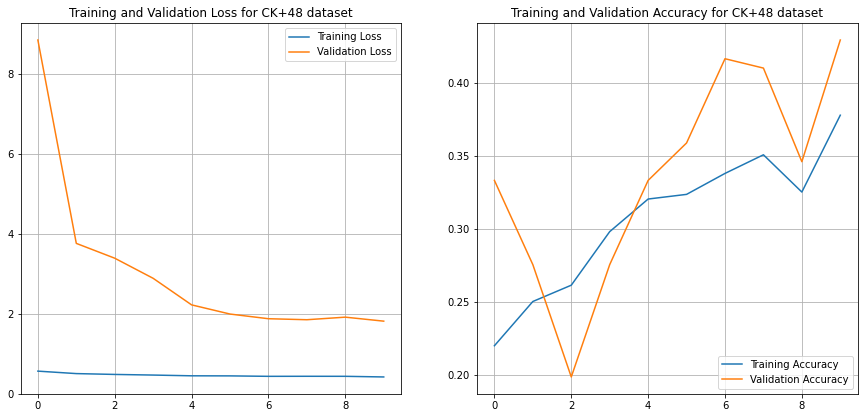

In [ ]:
plot_accuracy_and_loss(cknet_hist, "CK+48")

Again we check the evaluation

In [ ]:
ck_evaluation = cknet.evaluate(ck_test_ds, verbose =1)
ck_loss, ck_accr = ck_evaluation
print("ck_validation loss = {:.2f}% , ck_validation accuracy = {:.2f}%".format(ck_loss*100, ck_accr*100))

7/7 [==============================] - 1s 136ms/step - loss: 1.7971 - accuracy: 0.4141
ck_validation loss = 179.71% , ck_validation accuracy = 41.41%


Then display the confusion matrix

7/7 [==============================] - 1s 138ms/step
[DEBUG] Display 10 labels: ['disgust' 'surprise' 'neutral' 'sad' 'happy' 'disgust' 'happy' 'surprise'
 'disgust' 'fear']
[DEBUG] Display 10 predictions: ['surprise' 'surprise' 'surprise' 'surprise' 'disgust' 'disgust'
 'surprise' 'surprise' 'happy' 'disgust']


c:\Users\Haim Kalfon\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


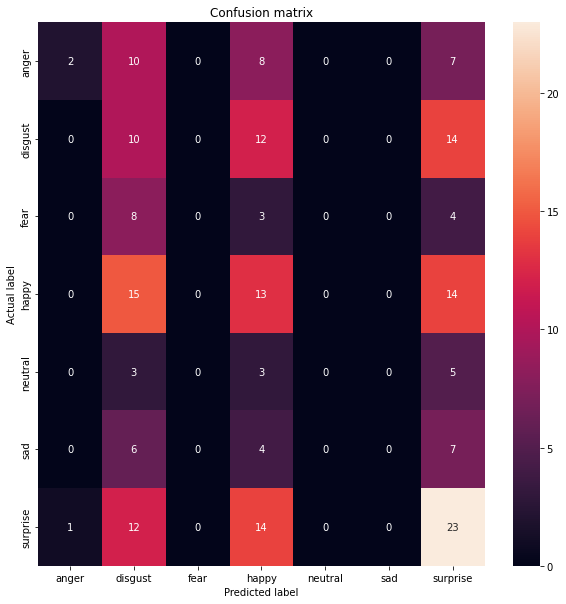

Anger
	Right Classified (True Negatives): 2
	 Total Missed Classification: 25
Disgust
	Right Classified (True Negatives): 10
	 Total Missed Classification: 26
Fear
	Right Classified (True Negatives): 0
	 Total Missed Classification: 15
Happy
	Right Classified (True Negatives): 13
	 Total Missed Classification: 29
Neutral
	Right Classified (True Negatives): 0
	 Total Missed Classification: 11
Sad
	Right Classified (True Negatives): 0
	 Total Missed Classification: 17
Surprise
	Right Classified (True Negatives): 23
	 Total Missed Classification: 27
[DEBUG] 0.24242424242424243

Percentage of right classifications is 24.24%"


In [ ]:
ck_predictions = cknet.predict(ck_test_ds, verbose = 1)
ck_class_index = np.argmax(ck_predictions, axis=1)

plot_confusion_matrix_for_test_dataset(ck_test_ds, ck_class_index)

Sadly we didnt get good reslut as expected.

Here are few possibles reasons:

* We don't have enough data, CK+48 dataset is not a big one
* Our model hyper-parameters are not optimal (we can change the learning rate as exemple)
* we dont have enough dropout layers
* Our network architecture is not complex enough
* We didnt give enough time to train

In this notbook (future work) we will try all of those approachs

To overcome those possible issues we will use those solutions (in order):

* To overcome the first possible issue (not enough data) we will try to merge few datasets (CK+48 and FER13)
* Based on previous research we will change the hyper-parameters
* Simply add fews
* Transfer learning might be a nice solution (based on trained model like Resnet50 and so on)
* Increasing EPOCH variable might help (we have set early stopping so it wont be a time wasting)